In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [3]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [5]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [7]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['measurement', 'station']


In [8]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


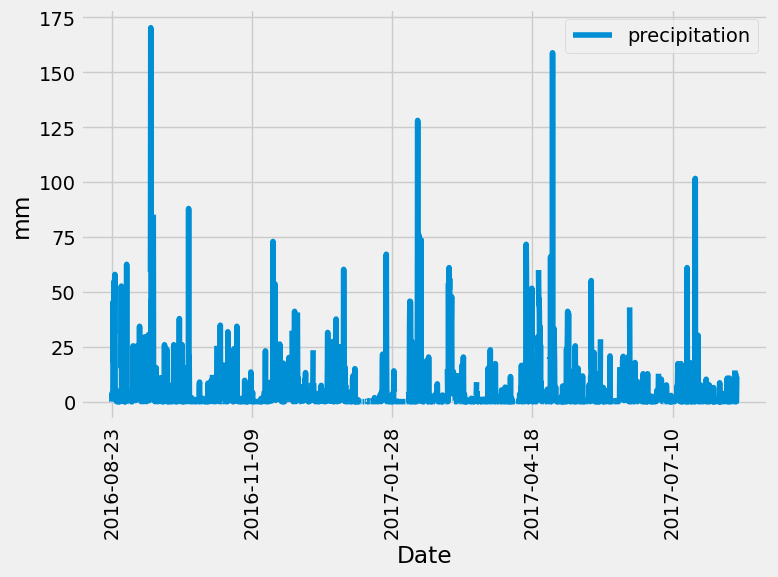

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)
one_year_ago_adjusted = one_year_ago - dt.timedelta(days=1)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago_adjusted).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='precipitation', figsize=(8,6))
plt.xlabel("Date")
plt.ylabel("mm")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stats = precipitation_df.describe()
print(precipitation_stats)

       precipitation
count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(total_stations)

9


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

for station, count in station_counts:
    print(f"{station}, {count}")

USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_counts[0][0]  
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active_station).all()

print(f"{temperature_stats[0][0]},{temperature_stats[0][1]},{temperature_stats[0][2]}")


12.2,29.4,22.03582251082252


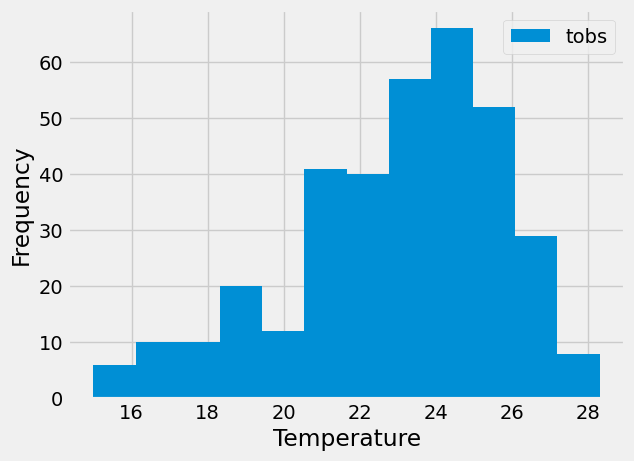

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
prev_year_tobs = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.station == most_active_station).\
                    filter(Measurement.date >= one_year_ago).all()

tobs_df = pd.DataFrame(prev_year_tobs, columns=['Date', 'Temperature'])

plt.hist(tobs_df['Temperature'], bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.show()

# Close Session

In [17]:
# Close Session
session.close()
